Triangulation
*Données*
- Motif mire 20mm

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image
import numpy as np
import cv2 as cv
from copy import deepcopy

from scipy.linalg import svd
import scipy

In [2]:
# Reading image

fname1 = "data/view1.jpg"
fname2 = "data/view2.jpg"

img1 = cv.cvtColor(cv.imread(fname1), cv.COLOR_BGR2GRAY)
img2 = cv.cvtColor(cv.imread(fname2), cv.COLOR_BGR2GRAY)

IMG_HEIGHT,IMG_WIDTH = img1.shape

In [23]:
# Trouver les points sur le damier gauche

img1_sub = deepcopy(img1)
img1_sub[:,IMG_WIDTH//2:] = 0

img2_sub = deepcopy(img2)
img2_sub[:,IMG_WIDTH//2:] = 0

ret,corners1 = cv.findChessboardCorners(img1_sub, (9,7))
corners1 = corners1.reshape((7*9,2))[::-1,:]

ret,corners2 = cv.findChessboardCorners(img2_sub, (9,7))
corners2 = corners2.reshape((7*9,2))[::-1,:]

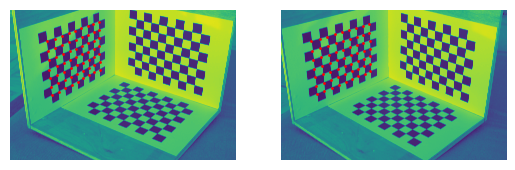

In [24]:
# Plot des points 

fig,(ax1,ax2) = plt.subplots(1,2)

ax1.imshow(img1)
ax1.scatter(corners1[:,0],corners1[:,1],s=1,c="r")
ax2.imshow(img2)
ax2.scatter(corners2[:,0],corners2[:,1],s=1,c="r")

ax1.set_axis_off()
ax2.set_axis_off()

In [25]:
# Associer un repère aux points du plan
corners_real = np.zeros((9*7,3))
dx = 20.
for i in range(7):
    for j in range(9):
        corners_real[i*9+j,0] = j*dx        
        corners_real[i*9+j,1] = i*dx

corners_real[:,2] = 1

In [63]:
img1.shape

(4000, 6000)

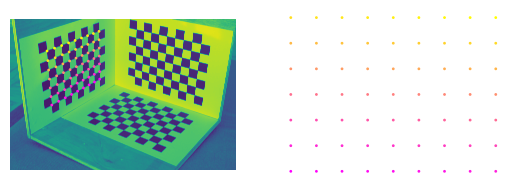

In [27]:
fig,(ax1,ax2) = plt.subplots(1,2)

ax1.imshow(img1)
ax1.scatter(corners1[:,0],corners1[:,1],s=1,c=range(9*7),cmap="spring")
ax2.scatter(corners_real[:,0],corners_real[:,1],s=1,c=range(9*7),cmap="spring")

ax1.set_axis_off()
ax2.set_aspect('equal', 'box')
ax2.set_axis_off()

In [48]:
# Construction matrice A
nbPts = 9*7
A1 = np.zeros((nbPts*3,9))
A2 = np.zeros((nbPts*3,9))

for n in range(nbPts):
    
    X1,X2,X3 = corners_real[n,:]

    x1,x2 = corners1[n,:]
    x3 = 1    
    
    A_ = np.array([
        [0, 0, 0, -x3*X1, -x3*X2, -x3*X3, x2*X1, x2*X2, x2*X3],
        [x3*X1, x3*X2, x3*X3, 0, 0, 0, -x1*X1, -x1*X2, -x1*X3],
        [-x2*X1, -x2*X2, -x2*X3, x1*X1, x1*X2, x1*X3, 0, 0, 0]
    ])
    
    A1[3*n:3*n+3,:] = A_
    
    x1,x2 = corners2[n,:]
    x3 = 1    
    
    A_ = np.array([
        [0, 0, 0, -x3*X1, -x3*X2, -x3*X3, x2*X1, x2*X2, x2*X3],
        [x3*X1, x3*X2, x3*X3, 0, 0, 0, -x1*X1, -x1*X2, -x1*X3],
        [-x2*X1, -x2*X2, -x2*X3, x1*X1, x1*X2, x1*X3, 0, 0, 0]
    ])
    
    A2[3*n:3*n+3,:] = A_

In [49]:
U,S,V = svd(A1)
H1 = V[-1,:].reshape((3,3))

U,S,V = svd(A2)
H2 = V[-1,:].reshape((3,3))

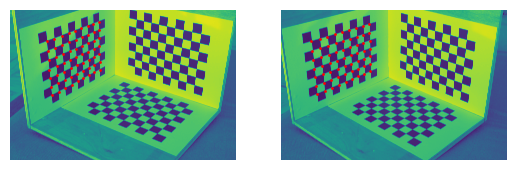

In [50]:
# verification des homographies : on reprojette des points du réel à l'image

corners1_b = np.zeros((nbPts,3))
corners2_b = np.zeros((nbPts,3))

for n in range(nbPts):
    corners1_b[n,:] = H1@corners_real[n,:]    
    corners2_b[n,:] = H2@corners_real[n,:]
    
    corners1_b[n,:] /= corners1_b[n,2]
    corners2_b[n,:] /= corners2_b[n,2]
    
fig,(ax1,ax2) = plt.subplots(1,2)

ax1.imshow(img1)
ax1.scatter(corners1_b[:,0],corners1_b[:,1],s=1,c="r")
ax2.imshow(img2)
ax2.scatter(corners2_b[:,0],corners2_b[:,1],s=1,c="r")

ax1.set_axis_off()
ax2.set_axis_off()

In [51]:
# On calcul la matrice de passage de l'image 1 à l'image 2

# matrice param interne caméra
K = np.array([
    [9.24884530e+03, 0.00000000e+00, 2.99965200e+03],
    [0.00000000e+00, 9.09644695e+03, 1.99981047e+03],
    [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]
])

iK = np.linalg.inv(K)

In [53]:
def getRotationTranspose(H):
    """Return the rotation and the transpose associated with a planar homography H"""

    Hp = iK@H
    Hp /= np.sqrt((Hp[:,0]**2).sum())
    R = np.array([Hp[:,0],Hp[:,1],np.cross(Hp[:,0],Hp[:,1])])
    t = Hp[:,2]
    U,_,Vh = svd(R)
    R = U@Vh
    
    return R,t

R1,t1 = getRotationTranspose(H1)
R2,t2 = getRotationTranspose(H2)

In [67]:
# R12 = R2@np.linalg.inv(R1)
R12 = R2@R1.T # éviter inverse 
t12 = t2 - R12@t1

In [93]:
Mp = np.zeros((3,4))
Mp[:,:3] = R12
Mp[:,3] = t12 

M = np.zeros((3,4))
Mp[:,:3] = np.eye(3)

P = K@M 
Pp = K@Mp

In [66]:
# get euler angles
from scipy.spatial.transform import Rotation

R12_rot = Rotation.from_matrix(R12)
angles = R12_rot.as_euler('zyx', degrees=True)
angles

array([179.96739452,   7.43214099,  -0.88710736])

In [71]:
A = np.ones((5,5))
mask = np.full((5,5),False)
mask[1,2] = True
A[mask] = 8
print(mask)
A

[[False False False False False]
 [False False  True False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]]


array([[1., 1., 1., 1., 1.],
       [1., 1., 8., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [102]:
# Reconstruction 3D 

# on récupère les coordonnées des damiers pour les 3 damiers pour les 2 images

corners = {
    'view1' : [np.array((9*7,2))]*3,
    'view2' : [np.array((9*7,2))]*3,
}

for img_name in ["view1","view2"]:
    
    fname = f"data/{img_name}.jpg"
    img = cv.cvtColor(cv.imread(fname), cv.COLOR_BGR2GRAY)
    IMG_HEIGHT,IMG_WIDTH = img.shape

    # Restrictions laissant un seul damier apparent
    img1 = deepcopy(img)
    img1[:,IMG_WIDTH//2:] = 0

    img2 = deepcopy(img)
    img2[:,:IMG_WIDTH//2] = 0

    img3 = deepcopy(img)
    img3[:IMG_HEIGHT//3,:] = 0
    
    for i,img_masked in enumerate([img1,img2,img3]):
        
        ret,corners_ = cv.findChessboardCorners(img_masked, (9,7))
        corners_ = corners_.reshape((7*9,2))[::-1,:]
        
        corners[img_name][i] = corners_

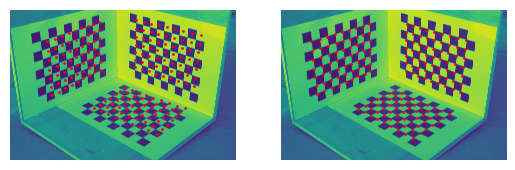

In [107]:
# plot corners

# Plot des points 

fig,(ax1,ax2) = plt.subplots(1,2)

ax1.imshow(img)
ax2.imshow(img)

for i in range(3):
    ax1.scatter(corners["view1"][i][:,0],corners["view1"][i][:,1],s=1,c="r")
    ax2.scatter(corners["view2"][i][:,0],corners["view2"][i][:,1],s=1,c="r")

ax1.set_axis_off()
ax2.set_axis_off()

In [110]:
# consrtruction de la matrice

NbPtsTot = 3*7*9
coord_3d = np.zeros((NbPtsTot,3))
A = np.zeros((4,4))

p1 = P[0,:]
p2 = P[1,:]
p3 = P[2,:]

p1p = Pp[0,:]
p2p = Pp[1,:]
p3p = Pp[2,:]

print(p1)

for i in range(NbPtsTot):
    
    nDamier = i//(7*9)
    nPt = i - nDamier*7*9
    
    print(i,nDamier,nPt)
    
    x,y = corners["view1"][nDamier][nPt,:]
    xp,yp = corners["view2"][nDamier][nPt,:]
    
    A = np.array([
        x*p3 - p1,
        y*p3 - p2,
        xp*p3p - p1p,
        yp*p3p - p2p
    ])
    
    print(A)
    
    
    _,_,V = svd(A)
    coord_3d[i,:] = V[-1,:3] 
    

[0. 0. 0. 0.]
0 0 0
1 0 1
2 0 2
3 0 3
4 0 4
5 0 5
6 0 6
7 0 7
8 0 8
9 0 9
10 0 10
11 0 11
12 0 12
13 0 13
14 0 14
15 0 15
16 0 16
17 0 17
18 0 18
19 0 19
20 0 20
21 0 21
22 0 22
23 0 23
24 0 24
25 0 25
26 0 26
27 0 27
28 0 28
29 0 29
30 0 30
31 0 31
32 0 32
33 0 33
34 0 34
35 0 35
36 0 36
37 0 37
38 0 38
39 0 39
40 0 40
41 0 41
42 0 42
43 0 43
44 0 44
45 0 45
46 0 46
47 0 47
48 0 48
49 0 49
50 0 50
51 0 51
52 0 52
53 0 53
54 0 54
55 0 55
56 0 56
57 0 57
58 0 58
59 0 59
60 0 60
61 0 61
62 0 62
63 1 0
64 1 1
65 1 2
66 1 3
67 1 4
68 1 5
69 1 6
70 1 7
71 1 8
72 1 9
73 1 10
74 1 11
75 1 12
76 1 13
77 1 14
78 1 15
79 1 16
80 1 17
81 1 18
82 1 19
83 1 20
84 1 21
85 1 22
86 1 23
87 1 24
88 1 25
89 1 26
90 1 27
91 1 28
92 1 29
93 1 30
94 1 31
95 1 32
96 1 33
97 1 34
98 1 35
99 1 36
100 1 37
101 1 38
102 1 39
103 1 40
104 1 41
105 1 42
106 1 43
107 1 44
108 1 45
109 1 46
110 1 47
111 1 48
112 1 49
113 1 50
114 1 51
115 1 52
116 1 53
117 1 54
118 1 55
119 1 56
120 1 57
121 1 58
122 1 59
123 1 60


In [111]:
from mpl_toolkits.mplot3d import Axes3D

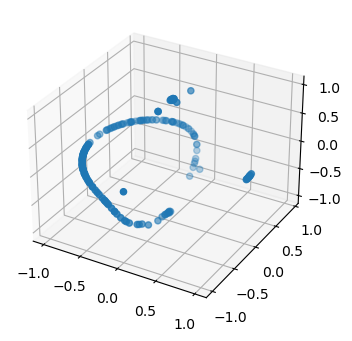

In [112]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(coord_3d[:,0],coord_3d[:,1],coord_3d[:,2])